In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, ToTensor, Resize, Normalize
from transformers import ViTModel
from torch.optim import Adam
from PIL import Image
import numpy as np
import os
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import sys
sys.path.insert(0,'f:/Meysam-Khodarahi/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/src/') 
#sys.path.insert(0,'C:/Users/Mey/Documents/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/src/')
from dataset import TripletDatasetFinal
from attention import AttentionLayer
from models import ViTWithAttention
from losses import TripletLossFinal
     
#   بارگذاری داده ها از پوشه ها
data_dir = 'f:/Meysam-Khodarahi/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/src/dataset'
#data_dir = 'C:/Users/Mey/Documents/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/src/dataset'
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")

# بارگذاری داده ها با ImageFolder
train_dataset = ImageFolder(train_dir)
val_dataset = ImageFolder(val_dir)
test_dataset = ImageFolder(test_dir)

# ایجاد TripletDataset
train_triplet_dataset = TripletDatasetFinal(train_dataset)
train_loader = DataLoader(train_triplet_dataset, batch_size=32, shuffle=True)

val_triplet_dataset = TripletDatasetFinal(val_dataset)
val_loader = DataLoader(val_triplet_dataset, batch_size=32, shuffle=True)

test_triplet_dataset = TripletDatasetFinal(test_dataset)
test_loader = DataLoader(test_triplet_dataset, batch_size=32, shuffle=True)

#   تعریف مدل، Optimizer و Loss Function
model_name = "google/vit-base-patch16-224"
model = ViTWithAttention(model_name)
optimizer = Adam(model.parameters(), lr=1e-5)
triplet_loss = TripletLossFinal(margin=1.0)

#   آموزش مدل و محاسبه Accuracy
num_epochs = 10
model.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    correct = 0
    total = 0

    for batch in train_loader:
        anchor, positive, negative,anchor_label = batch

        # استخراج ویژگی ها (embeddings)
        anchor_features,_ = model(anchor)
        positive_features,_ = model(positive)
        negative_features,_ = model(negative)

        # محاسبه ی loss
        loss = triplet_loss(anchor_features, positive_features, negative_features)
        epoch_loss += loss.item()

        # محاسبه accuracy
        distance_positive = F.pairwise_distance(anchor_features, positive_features)
        distance_negative = F.pairwise_distance(anchor_features, negative_features)
        predictions = (distance_positive < distance_negative).float()  # 1 اگر درست، 0 اگر نادرست
        correct += predictions.sum().item()
        total += predictions.size(0)

        # به روزرسانی مدل
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    accuracy = correct / total
    print(f"Epoch {epoch + 1}, Loss: {epoch_loss / len(train_loader)}, Accuracy: {accuracy * 100:.2f}%")

#   ذخیره سازی مدل Fine-Tuned
torch.save(model.state_dict(), "f:/Meysam-Khodarahi/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/vitWithAttentionState12.pth")
torch.save(model, "f:/Meysam-Khodarahi/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/vitWithAttention12.pth")
#torch.save(model.state_dict(), "C:/Users/Mey/Documents/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/vitWithAttentionState.pth")
#torch.save(model, "C:/Users/Mey/Documents/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/vitWithAttention.pth")

    

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Loss: 0.37075183168053627, Accuracy: 86.22%
Epoch 2, Loss: 0.32159075513482094, Accuracy: 87.11%
Epoch 3, Loss: 0.6728901565074921, Accuracy: 88.89%
Epoch 4, Loss: 0.21206698939204216, Accuracy: 90.67%
Epoch 5, Loss: 0.21841351315379143, Accuracy: 89.33%
Epoch 6, Loss: 0.21133926883339882, Accuracy: 92.44%
Epoch 7, Loss: 0.17812421917915344, Accuracy: 92.00%
Epoch 8, Loss: 0.18970270827412605, Accuracy: 92.44%
Epoch 9, Loss: 0.9754401035606861, Accuracy: 91.56%
Epoch 10, Loss: 0.13400163874030113, Accuracy: 95.56%


In [3]:
# تعداد کلاس ها
num_classes = len(train_dataset.classes)
print(f"تعداد کلاس ها: {num_classes}")

# لیست کلاس ها
classes = train_dataset.classes
print(f"کلاس ها: {classes}")

# تعداد نمونه ها در هر کلاس
class_counts = {cls: 0 for cls in classes}
for target in train_dataset.targets:
    class_counts[classes[target]] += 1

print("تعداد نمونه ها در هر کلاس:")
for cls, count in class_counts.items():
    print(f"{cls}: {count}")


تعداد کلاس ها: 15
کلاس ها: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
تعداد نمونه ها در هر کلاس:
Pepper__bell___Bacterial_spot: 15
Pepper__bell___healthy: 15
Potato___Early_blight: 15
Potato___Late_blight: 15
Potato___healthy: 15
Tomato_Bacterial_spot: 15
Tomato_Early_blight: 15
Tomato_Late_blight: 15
Tomato_Leaf_Mold: 15
Tomato_Septoria_leaf_spot: 15
Tomato_Spider_mites_Two_spotted_spider_mite: 15
Tomato__Target_Spot: 15
Tomato__Tomato_YellowLeaf__Curl_Virus: 15
Tomato__Tomato_mosaic_virus: 15
Tomato_healthy: 15


In [5]:
import torch
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data import DataLoader
import sys
sys.path.insert(0,'f:/Meysam-Khodarahi/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/src/') 
from metrics import MetricsFinal
#sys.path.insert(0,'C:/Users/Mey/Documents/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/src/')
from dataset import TripletDatasetFinal
from attention import AttentionLayer
from models import ViTWithAttention
from losses import TripletLossFinal
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, ToTensor, Resize, Normalize
from transformers import ViTModel
from torch.optim import Adam
from PIL import Image
 

# بارگذاری مدل ( مدل قبلاً آموزش دیده و ذخیره شده است)
model = ViTWithAttention("google/vit-base-patch16-224")
model.load_state_dict(torch.load("f:/Meysam-Khodarahi/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/vitWithAttentionState1.pth"))  # بارگذاری وزن‌های مدل
#model.load_state_dict(torch.load("C:/Users/Mey/Documents/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/vitWithAttentionState.pth"))  # بارگذاری وزن‌های مدل

# استفاده از کد ارزیابی
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


#   بارگذاری داده ها از پوشه ها
data_dir = 'f:/Meysam-Khodarahi/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/src/dataset'
#data_dir = 'C:/Users/Mey/Documents/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/src/dataset'
test_dir = os.path.join(data_dir, "test")
# بارگذاری داده ها با ImageFolder
test_dataset = ImageFolder(test_dir)
# ایجاد TripletDataset
test_triplet_dataset = TripletDatasetFinal(test_dataset)
test_loader = DataLoader(test_triplet_dataset, batch_size=32, shuffle=True)

# باید test_loader در دسترس باشد
MetricsFinal.evaluate_triplet_model(model, test_loader, device)


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\pc\AppData\Local\Temp\ipykernel_5172\901047172.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serializati

Accuracy: 84.09%
Precision: 1.00
Recall: 0.84
F1 Score: 0.91


C:\Users\pc\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.8408539543910722, 1.0, 0.8408539543910722, 0.9135477069056405)

f:/Meysam-Khodarahi/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/src\CustomeTsne.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)  # تبدیل برچسب ها به tensor و انتقال به دستگاه


Unique labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


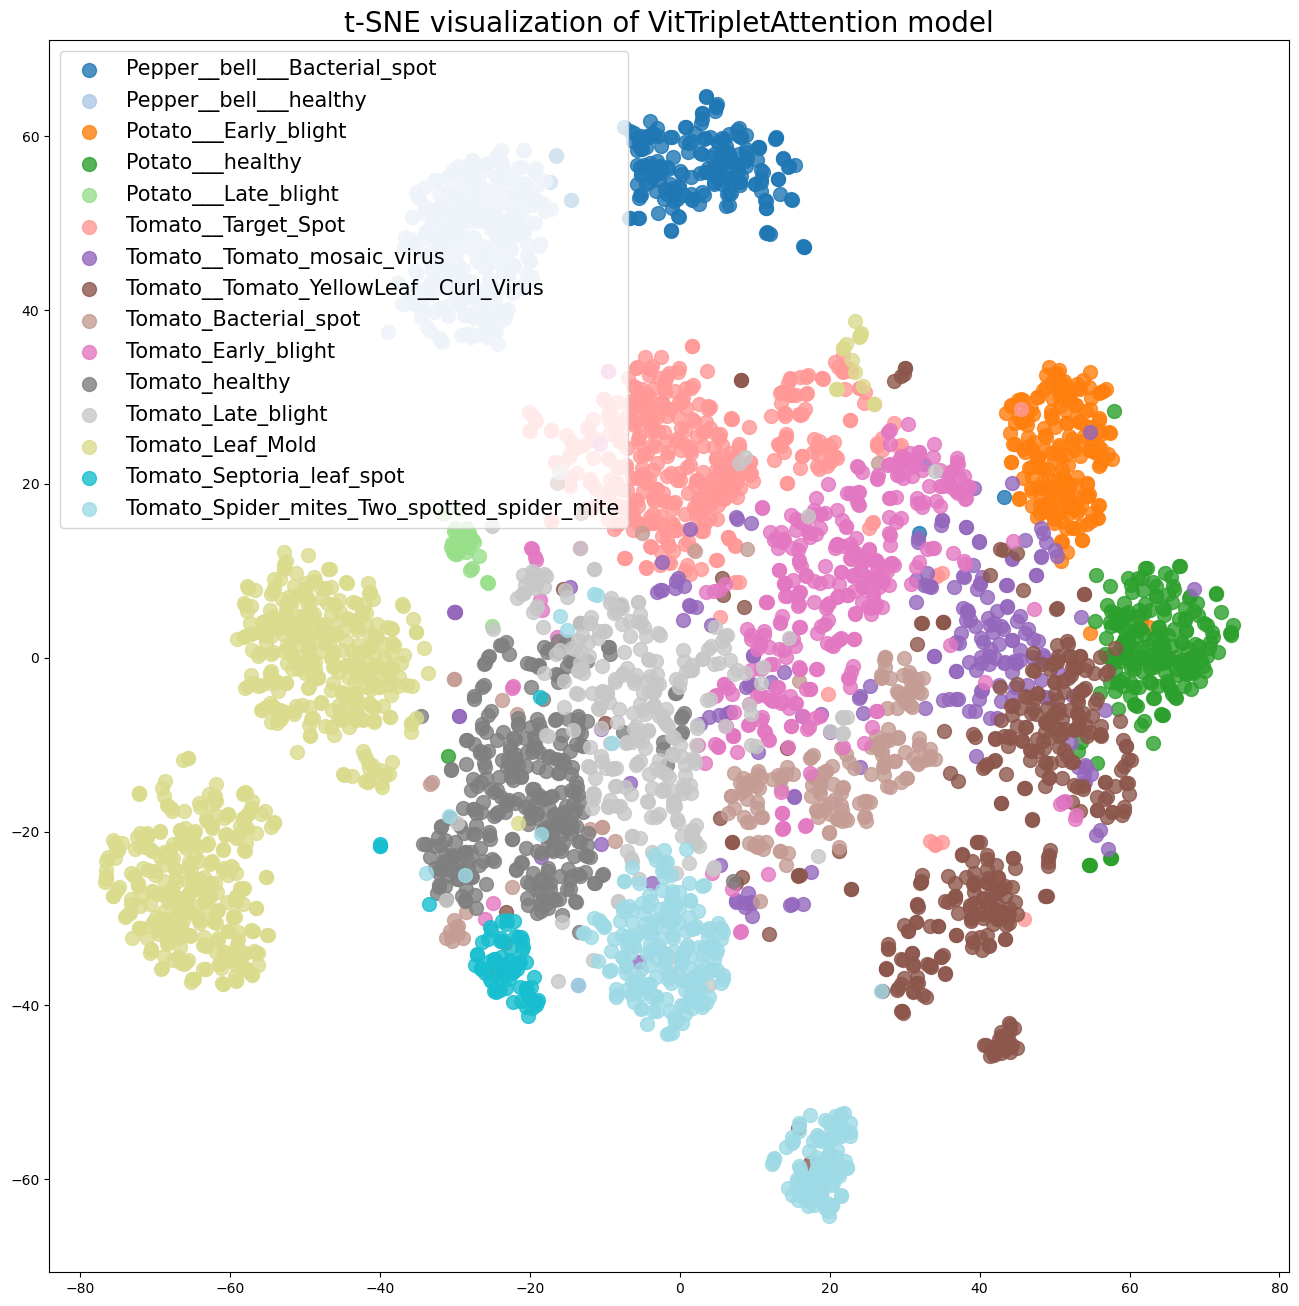

In [7]:
from sklearn.preprocessing import LabelEncoder
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import sys
sys.path.insert(0,'f:/Meysam-Khodarahi/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/src/') 
#sys.path.insert(0,'C:/Users/Mey/Documents/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/src/')
from dataset import TripletDatasetFinal
import CustomeTsne

# بارگذاری داده ها و استفاده از کد
data_dir = 'f:/Meysam-Khodarahi/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/src/dataset'
#data_dir = 'C:/Users/Mey/Documents/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/src/dataset'
test_dir = os.path.join(data_dir, "test")
test_dataset = ImageFolder(test_dir)

# ایجاد TripletDataset و DataLoader
test_triplet_dataset = TripletDatasetFinal(test_dataset)
test_loader = DataLoader(test_triplet_dataset, batch_size=32, shuffle=True)

# فراخوانی تابع
CustomeTsne.vis_tSNE(model, test_loader, device, backbone='VitTripletAttention')


In [9]:
from torchvision import transforms
from PIL import Image
import torch
from metrics import MetricsFinal
import sys
sys.path.insert(0,'f:/Meysam-Khodarahi/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/src/') 
#sys.path.insert(0,'C:/Users/Mey/Documents/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/src/')
from dataset import TripletDatasetFinal
from attention import AttentionLayer
from models import ViTWithAttention
from losses import TripletLossFinal


# تعریف پیش پردازش تصویر (باید مشابه با پیش پردازش داده های آموزشی باشد)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # تغییر اندازه تصویر به 224x224
    transforms.ToTensor(),  # تبدیل تصویر به تنسور
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # نرمال سازی تصویر
])

# بارگذاری تصویر
data_dir = 'f:/Meysam-Khodarahi/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/src/dataset'
#data_dir = 'C:/Users/Mey/Documents/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/src/dataset'
image_path = data_dir+"/test/Tomato_Early_blight/"+"3be94535-c405-4f67-99cb-6ffc5f596639___RS_Erly.B 7783.JPG"
image = Image.open(image_path).convert("RGB")

# اعمال پیش پردازش
image = transform(image).unsqueeze(0)  # unsqueeze برای اضافه کردن بعد batch_size (1,)
# بارگذاری مدل ( مدل قبلاً آموزش دیده و ذخیره شده است)
model = ViTWithAttention("google/vit-base-patch16-224")
model.load_state_dict(torch.load("f:/Meysam-Khodarahi/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/vitWithAttentionState1.pth"))  # بارگذاری وزن های مدل
#model.load_state_dict(torch.load("C:/Users/Mey/Documents/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/vitWithAttentionState.pth"))  # بارگذاری وزن های مدل

# قرار دادن مدل در حالت ارزیابی
model.eval()
# عبور تصویر از مدل برای دریافت ویژگی های CLS Token
with torch.no_grad():  # غیرفعال کردن محاسبات گرادیان
    outputs = model(image)  # عبور تصویر از مدل

# ویژگی های CLS Token از آخرین لایه
cls_features = outputs  # در مدل  این ویژگی ها از لایه attention  دریافت می شود
print(cls_features)

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\pc\AppData\Local\Temp\ipykernel_5172\1668530517.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serializat

(tensor([[-1.4598e-01, -4.6437e-01,  7.1113e-01, -1.3891e-01,  6.9119e-01,
         -4.9629e-02, -3.0127e-01,  4.8993e-01,  6.5854e-02,  8.6858e-01,
         -3.1153e-02,  1.9532e-01,  5.2291e-02, -9.3722e-01, -2.7697e-01,
          1.8512e-01, -6.3749e-01, -3.6747e-01, -4.0213e-01, -2.3374e+00,
         -1.0293e+00, -1.2232e+00, -4.0054e-01, -4.6632e-01,  5.3292e-02,
          4.2184e-01,  4.2950e-02,  4.7215e-02,  3.3997e-01, -1.6906e-01,
         -1.0011e+00,  5.3123e-01, -9.2287e-01,  8.3812e-01, -2.8369e-01,
          2.0602e-01, -7.9800e-03, -1.3874e-01, -8.3891e-01,  4.0063e-01,
          6.4557e-01, -2.8733e-01, -5.4810e-02, -6.2305e-01,  6.5817e-01,
         -2.3311e-01,  1.0544e+00, -1.9423e-02, -4.0197e-01, -2.4509e-01,
         -6.1295e-01, -7.5804e-02,  1.5348e+00, -3.8323e-01, -1.2442e+00,
          1.1898e+00, -2.2277e-01,  1.1296e+00,  2.6125e-01, -4.4700e-01,
         -3.9443e-02, -5.1613e-01,  1.6313e+00,  2.0389e-01,  1.1975e-01,
         -5.8867e-01, -9.7333e-01, -2

In [10]:
import torch
import torch.nn.functional as F
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from PIL import Image
import numpy as np
from torch.utils.data import DataLoader
from dataset import TripletDatasetFinal
from attention import AttentionLayer
from models import ViTWithAttention
from losses import TripletLossFinal
import os
from torchvision.datasets import ImageFolder

# 1. تعریف transform برای پیش پردازش تصویر
transform = Compose([
    Resize((224, 224)),  # تغییر اندازه تصاویر به 224x224
    ToTensor(),  # تبدیل تصاویر به تانسور
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # نرمال سازی
])

# 2. تابع برای محاسبه ویژگی های مرجع هر کلاس
def compute_reference_features(model, train_loader, train_dataset):
    model.eval()  # مدل را در حالت evaluation قرار دهید
    reference_features = {}  # دیکشنری برای ذخیره ویژگی های مرجع هر کلاس

    # حلقه روی تمام کلاس ها
    for cls_idx, cls in enumerate(train_dataset.classes):
        cls_features = []  # لیست برای ذخیره ویژگی های تمام تصاویر این کلاس

        # حلقه روی تمام تصاویر این کلاس
        for batch in train_loader:
            anchor, positive, negative, anchor_label = batch

            # فقط تصاویر مربوط به کلاس فعلی را انتخاب کنید
            mask = (anchor_label == cls_idx)  # ایجاد ماسک برای تصاویر این کلاس
            if mask.any():  # اگر حداقل یک تصویر از این کلاس وجود دارد
                with torch.no_grad():
                    features = model.get_embedding(anchor[mask])  # استخراج ویژگی ها
                    cls_features.append(features)

        # میانگین ویژگی های این کلاس
        if cls_features:  # اگر لیست خالی نبود
            cls_features = torch.cat(cls_features, dim=0)  # تبدیل لیست به تانسور
            reference_features[cls] = cls_features.mean(dim=0)  # میانگین ویژگی ها

    return reference_features

# 3. تابع برای پیش بینی کلاس تصویر
def predict_image_class(image_path, model, transform, reference_features, train_dataset):
    # بارگذاری تصویر
    image = Image.open(image_path).convert("RGB")
    
    # پیش پردازش تصویر
    image_tensor = transform(image).unsqueeze(0)  # اضافه کردن بعد batch
    
    # استخراج ویژگی ها
    with torch.no_grad():
        features = model.get_embedding(image_tensor)
    
    # محاسبه فاصله ها با کلاس های مختلف
    distances = {}
    for cls, ref_feature in reference_features.items():
        distance = F.pairwise_distance(features, ref_feature.unsqueeze(0))  # محاسبه فاصله
        distances[cls] = distance.item()
    
    # پیدا کردن کلاس با کمترین فاصله
    predicted_class = min(distances, key=distances.get)
    
    return predicted_class

# 4. بارگذاری مدل آموزش دیده
model_path = "f:/Meysam-Khodarahi/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/vitWithAttention.pth"
# model_path = "C:/Users/Mey/Documents/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/vitWithAttention.pth"
model = torch.load(model_path)
model.eval()  # مدل را در حالت evaluation قرار دهید

# 5. بارگذاری داده های آموزش
data_dir = 'f:/Meysam-Khodarahi/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/src/dataset'
#data_dir = 'C:/Users/Mey/Documents/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/src/dataset'
train_dir = os.path.join(data_dir, "train")
train_dataset = ImageFolder(train_dir)
train_triplet_dataset = TripletDatasetFinal(train_dataset)
train_loader = DataLoader(train_triplet_dataset, batch_size=32, shuffle=True)

# 6. محاسبه ویژگی های مرجع
reference_features = compute_reference_features(model, train_loader, train_dataset)


# 7. تست تابع با یک تصویر نمونه
# بارگذاری تصویر
data_dir = 'f:/Meysam-Khodarahi/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/src/dataset'
#data_dir = 'C:/Users/Mey/Documents/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/src/dataset'
image_path = data_dir+"/test/Tomato_Early_blight/"+"3be94535-c405-4f67-99cb-6ffc5f596639___RS_Erly.B 7783.JPG"
predicted_class = predict_image_class(image_path, model, transform, reference_features, train_dataset)
print(f"Predicted Class: {predicted_class}")

C:\Users\pc\AppData\Local\Temp\ipykernel_5172\1650014876.py:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


Predicted Class: Tomato_Early_blight


In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

from PIL import Image
import numpy as np
from torch.utils.data import DataLoader
from dataset import TripletDatasetFinal
from attention import AttentionLayer
from models import ViTWithAttention
from losses import TripletLossFinal
import os
from torchvision.datasets import ImageFolder
from PIL import Image

# تعریف لایه‌ی توجه (AttentionLayer)
# class AttentionLayer(nn.Module):
#     def __init__(self, feature_dim):
#         super(AttentionLayer, self).__init__()
#         self.attention = nn.Sequential(
#             nn.Linear(feature_dim, feature_dim // 2),
#             nn.ReLU(),
#             nn.Linear(feature_dim // 2, 1),
#             nn.Softmax(dim=1)
#         )

#     def forward(self, x):
#         attention_weights = self.attention(x)  # (batch_size, sequence_length, 1)
#         weighted_features = x * attention_weights  # (batch_size, sequence_length, feature_dim)
#         return weighted_features.sum(dim=1), attention_weights  # بازگرداندن وزن‌های توجه

# # تعریف مدل ViT با لایه‌ی توجه
# class ViTWithAttention(nn.Module):
#     def __init__(self, model_name):
#         super(ViTWithAttention, self).__init__()
#         self.vit = ViTModel.from_pretrained(model_name)
#         self.attention = AttentionLayer(self.vit.config.hidden_size)

#     def forward(self, x):
#         outputs = self.vit(x)
#         last_hidden_state = outputs.last_hidden_state  # (batch_size, sequence_length, hidden_size)
#         features, attention_weights = self.attention(last_hidden_state)  # (batch_size, hidden_size), (batch_size, sequence_length, 1)
#         return features, attention_weights

#   بارگذاری مدل آموزش دیده
model_path = "f:/Meysam-Khodarahi/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/vitWithAttention1.pth"
# model_path = "C:/Users/Mey/Documents/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/vitWithAttention.pth"
model = torch.load(model_path)
#model.eval()  # مدل را در حالت evaluation قرار دهید

# تابع ایجاد نقشه حرارتی
def create_heatmap(image, attention_weights, patch_size=16):
    # ابعاد تصویر اصلی
    W, H = image.size  # PIL.Image از متد size استفاده می‌کند
    
    # ابعاد وزن های توجه
    num_patches_h = H // patch_size
    num_patches_w = W // patch_size
    
    # تبدیل وزن های توجه به ابعاد پچ ها
    attention_weights = attention_weights.squeeze().cpu().numpy()  # حذف ابعاد اضافی
    
    # حذف توکن کلاس (اولین توکن)
    attention_weights = attention_weights[1:]  # از توکن دوم به بعد
    
    # بررسی ابعاد
    expected_num_patches = num_patches_h * num_patches_w
    if attention_weights.shape[0] != expected_num_patches:
        raise ValueError(f"تعداد وزن‌های توجه ({attention_weights.shape[0]}) با تعداد پچ‌ها ({expected_num_patches}) مطابقت ندارد.")
    
    # تغییر شکل وزن‌های توجه به ابعاد پچ‌ها
    attention_weights = attention_weights.reshape(num_patches_h, num_patches_w)
    
    # افزایش اندازه نقشه حرارتی به ابعاد تصویر اصلی
    heatmap = cv2.resize(attention_weights, (W, H), interpolation=cv2.INTER_CUBIC)
    
    return heatmap



# تابع نمایش نقشه حرارتی روی تصویر
def visualize_attention(image, heatmap):
    # نمایش تصویر اصلی
    plt.imshow(image)
    
    # نمایش نقشه حرارتی روی تصویر
    plt.imshow(heatmap, alpha=0.5, cmap='jet')  # alpha برای شفافیت
    plt.colorbar()  # نمایش رنگ های نقشه حرارتی
    plt.axis('off')  # غیرفعال کردن محورها
    plt.show()

# بارگذاری تصویر اصلی
data_dir = 'f:/Meysam-Khodarahi/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/src/dataset'
#data_dir = 'C:/Users/Mey/Documents/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/src/dataset'
image_path = data_dir+"/test/Tomato_Early_blight/"+"3be94535-c405-4f67-99cb-6ffc5f596639___RS_Erly.B 7783.JPG"
image = Image.open(image_path).convert("RGB")  # تبدیل به RGB

# تبدیل تصویر به تانسور و پیش پردازش
transform = Compose([
    Resize((224, 224)),  # تغییر اندازه تصویر به 224x224
    ToTensor(),  # تبدیل به تانسور
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # نرمال سازی
])
image_tensor = transform(image).unsqueeze(0)  # اضافه کردن بعد batch
 

# تعریف مدل و استخراج وزن‌های توجه
#model = ViTWithAttention(model_name="google/vit-base-patch16-224")
# model_path = "f:/Meysam-Khodarahi/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/vitWithAttention.pth"
# model_path = "C:/Users/Mey/Documents/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/vitWithAttention.pth"
# model = torch.load(model_path)
with torch.no_grad():
    _, attention_weights = model(image_tensor)  # وزن های توجه را دریافت میکنیم

print(attention_weights.shape)
# ایجاد نقشه حرارتی
heatmap = create_heatmap(image, attention_weights, patch_size=16)
 
# نمایش نقشه حرارتی روی تصویر
visualize_attention(image, heatmap)
 

C:\Users\pc\AppData\Local\Temp\ipykernel_5172\777925810.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


torch.Size([1, 197, 1])


ValueError: تعداد وزن‌های توجه (196) با تعداد پچ‌ها (256) مطابقت ندارد.